<font size ="4">**Importing all the libraries**</font>

In [8]:
# Importing necessary Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import nltk
import os

# Downloading required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
from sklearnex import patch_sklearn
patch_sklearn()
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bansa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bansa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


<font size ="4">**Downloading the dataset and extracting it to the appropriate data directory.**</font>

In [9]:
# Define the directory path where the data will be stored
data_directory = 'data/'

# Check if the data directory already exists
if not os.path.exists(data_directory):
    # If the directory does not exist, create it
    !mkdir data/
    
    # Download the dataset zip file from the provided URL to the data directory
    !wget https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip --directory-prefix=data/
    
    # Unzip the dataset file to the data directory
    !unzip data/News-_dataset.zip -d data/


<font size="4">**Read the data csv file**</font>

In [10]:
# Read the CSV file containing fake data into a Pandas DataFrame
fake_data = pd.read_csv('data/Fake.csv')

# Display the first few rows of the DataFrame to get a glimpse of the data
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [11]:
# Read the CSV file containing true data into a Pandas DataFrame
true_data = pd.read_csv('data/True.csv')

# Display the first few rows of the DataFrame to get a glimpse of the data
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Assigning Classes to the Dataset

In [12]:
# Assigning labels to the true and fake data
true_data["label"] = 1  # Assign label 1 to true_data indicating true news
fake_data["label"] = 0  # Assign label 0 to fake_data indicating fake news


Merging Both the Dataset

In [13]:
data = pd.concat([true_data, fake_data], axis=0)

Visualization of the text data based on subject column

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

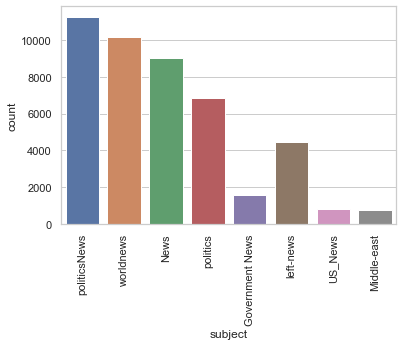

In [14]:
plt.figure(figsize = (6,4))   # specifying the size of the figure
sns.set(style = "whitegrid",font_scale = 1.0)   # styling of the figure
chart = sns.countplot(x = "subject", data = data)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

<font size="4">**Data preprocessing**</font>

In [15]:
data['text'] = data['title'] +' '+data['text']
# Either you could data.drop["column names"] or del data["column names"]
del data['title']
del data['subject']
del data['date']

In [16]:
data.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


As the title, author column will not going to be helpful in identification of the news. So, we can drop these column.

In [17]:
data.shape

(44898, 2)

Check if there is any null value (If so, then we will drop those rows)

In [18]:
data.isnull().sum() # get the count of missing/NULL values for each column. if present remove missing values

text     0
label    0
dtype: int64

 Now we have to shuffle the dataset to prevent the model to get bias

In [19]:
#Shuffling the data by sampling it randomly, then resetting the index and dropping the previous index column
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,text,label
0,May says will 'honor commitments' to EU BRUSSE...,1
1,PRICELESS: Watch Bill Clinton Defend Hillary’s...,0
2,NO MORE FUN FREEBIES ON BACKS OF HARD WORKING ...,0
3,White House budget chief expects to release bu...,1
4,Vatican would see U.S. Paris deal exit as slap...,1


Now Let’s explore the unique values in the each category using below code.

<Axes: xlabel='label', ylabel='count'>

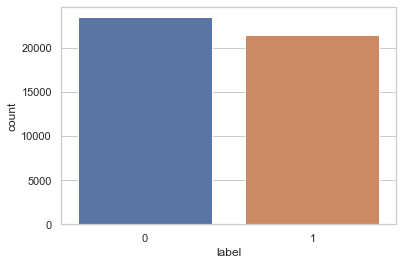

In [20]:
sns.countplot(data=data,
              x='label',
              order=data['label'].value_counts().index)

<font size="4">**Data Cleaning**</font>

Once we have all the required modules, we can create a function name preprocess text. This function will preprocess all the data given as input.

In [21]:
def preprocess_text(text):
    # TODO: create a function to clean your data
 
    # Remove links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove special symbols and non-word characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove whitespaces and newline characters
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading and trailing whitespaces
    text = text.strip()
    
    # Removing numbers
    text = re.sub(r'\d+', '', text)
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)

    return text
data['text'] = data['text'].apply(preprocess_text)

<font size="4">**Converting text into Vectors**</font>

In [22]:
#TODO: explore different vectorization available with sklearn.feature_extraction.text
# Split the data
X = data['text'].values 
Y = data['label'].values 

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


<font size="4">**Model training, Evaluation, and Prediction**</font>

In [ ]:
#TODO: Model training and print the accuracy score 

# Initialize and train the model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train_vec, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_vec)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
# Display the Confusion matrix of Results from your classification algorithm

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)


In [ ]:
# Prediction of the news
def predict_fake_news(news):
    # Preprocess the user input
    preprocessed_input = preprocess_text(news)

    # Vectorize the user input
    user_input_vec = vectorizer.transform([preprocessed_input])

    # Make the prediction
    prediction = model.predict(user_input_vec)

    # Interpret the prediction
    if prediction[0] == 1:
        return "\nThe news is classified as TRUE."
    else:
        return "\nThe news is classified as FAKE ."

# Prediction of the user input news
title = input("Enter the news title: \n")
article = input("\nEnter the news article: \n")
text=title+" "+article
prediction = predict_fake_news(text)
print(prediction)
